### Figure 3
 - Explained variance each subject individually
 

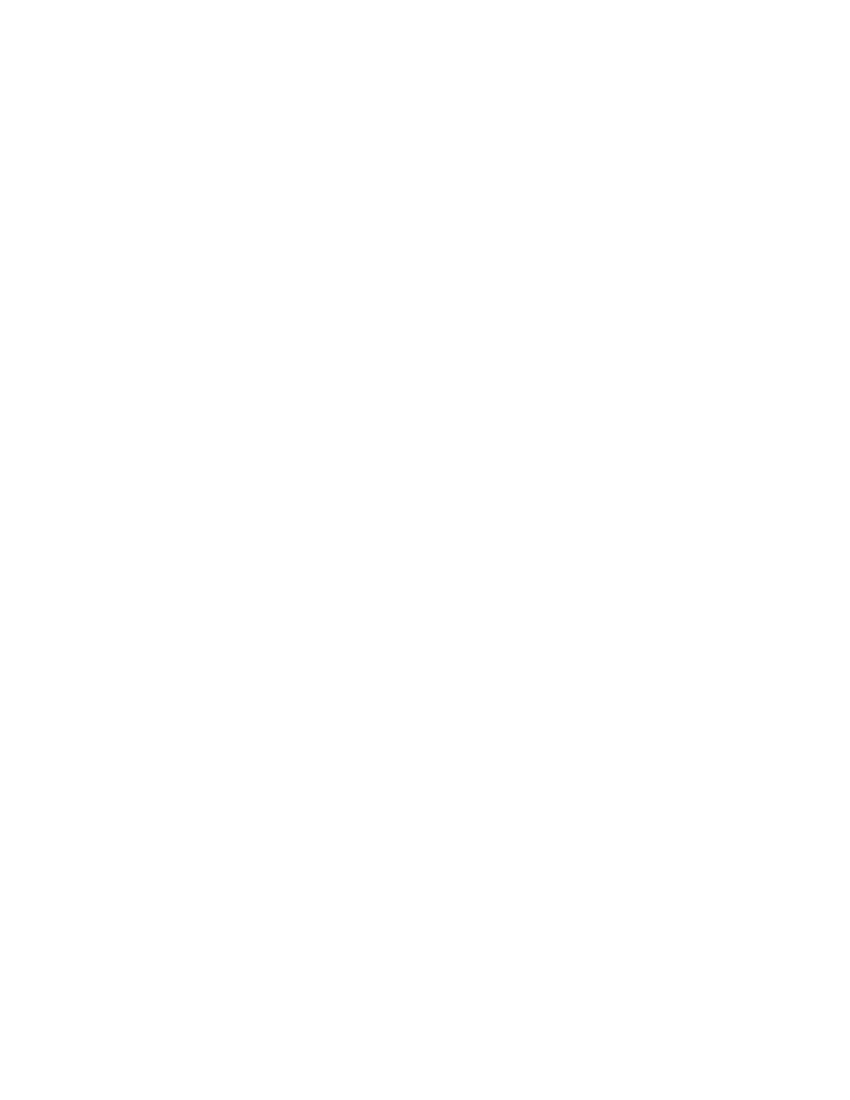

In [126]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import subjects
from neuropy import plotting

grpdata = subjects.GroupData()
group = ['NSD','SD']

ev_states = grpdata.ev_brainstates
ev_df = grpdata.ev_pooled
ev_df['ev_diff'] = ev_df['ev']-ev_df['rev']

fig = plotting.Fig(grid=(10,4))
filename = subjects.figpath_sd / 'figure3'
caption = "Figure 3: MAZE reactivation during POST. \n(A) Explained variance (EV) in POST for each session of SD (orange) and NSD (purple) group with chance levels (gray). Error bars indicate +/- stdev. \n(B) Mean explained variance pooled across SD and NSD sessions. Error bars indicate +/- SEM."

### Individual EVs

In [127]:
from neuropy.plotting import plot_hypnogram
from neuropy.core import Epoch

# y_lim = [0.4, 0.2, 0.27, 0.15, 0.27, 0.25]
errorbar_kw = dict(alpha=0.5, linewidth=0, ec=None)
names = ev_df.name.unique()
ev_colors = [subjects.nsd.color(1.2), subjects.sd.color(1.2)]

for row, name in enumerate(names):
    df_name = ev_df[ev_df.name == name]
    states_name = ev_states[ev_states.name == name]
    sex = df_name.sex.iloc[0]
    grps_name = df_name.grp.unique()[::-1]

    subfig = fig.fig.add_subfigure(fig.gs[row, :2])
    axs = subfig.subplots(2, 2, sharey="row", gridspec_kw=dict(height_ratios=[1, 4]))

    for i, grp in enumerate(grps_name):
        states = states_name[states_name["grp"] == grp]
        df = df_name[df_name["grp"] == grp]
        color = ev_colors[0] if grp == "NSD" else ev_colors[1]
        col = 0 if grp == "NSD" else 1

        t, ev, ev_err, rev, rev_err = (
            df["Zt"],
            df["ev"],
            df["ev_std"],
            df["rev"],
            df["rev_std"],
        )

        ax_hypno, ax = axs[:, col]

        epoch = Epoch(states)
        plot_hypnogram(epoch, ax=ax_hypno, collapsed=False)

        ax.fill_between(t, rev - rev_err, rev + rev_err, color="gray", **errorbar_kw)
        ax.plot(t, rev, color="gray")
        ax.fill_between(t, ev - ev_err, ev + ev_err, color=color, **errorbar_kw)
        ax.plot(t, ev, color=color)

        sex_symbol = "$\u2640$" if sex == "female" else "$\u2642$"
        sex_color = "#F50057" if sex == "female" else "#2962FF"
        if i == 0:
            ax.set_ylabel("EV")
            fig.legend(ax, [name + sex_symbol], color=[sex_color], x=-0.4, y=1)

        ax.set_xticks([1, 3, 5, 7, 9])

### Pooled Evs

In [128]:
pooled_ev_hour_df = []
for i, grp in enumerate(group):
    grp_df = ev_df[ev_df["grp"] == grp]
    subs = np.unique(grp_df["sub"])
    for sub_i, sub in enumerate(subs):
        sub_df = grp_df[grp_df["sub"] == sub]
        zt, ev = sub_df["Zt"], sub_df["ev"]
        ev_h, t = stats.binned_statistic(zt, ev, bins=np.arange(10))[:2]
        pooled_ev_hour_df.append(
            pd.DataFrame({"Zt": t[1:], "ev": ev_h, "sub": sub, "grp": grp})
        )
pooled_ev_hour_df = pd.concat(pooled_ev_hour_df, ignore_index=True)

ev_colors = [subjects.nsd.color(1.3), subjects.sd.color(1.2)]
val = [-0.22, 0.22]

ax = fig.subplot(fig.gs[:1, 2])
for i, grp in enumerate(group):
    df = pooled_ev_hour_df[pooled_ev_hour_df["grp"] == grp]
    mean_ev = df.groupby("Zt").mean()
    sem_ev = df.groupby("Zt").sem(ddof=0).ev

    ax.bar(
        mean_ev.index + val[i],
        mean_ev.ev,
        ec=ev_colors[i],
        color="w",
        yerr=np.vstack([np.zeros(len(sem_ev)),sem_ev]),
        # alpha=0.4,
        capsize=1.8,
        width=0.35,
        # ec='#7e7c7c',
        # ecolor="#545454",
        ecolor=ev_colors[i],
        # linewidth=2,
        error_kw=dict(elinewidth=0.7),
    )
ax.set_xticks([1, 3, 5, 7, 9])
ax.set_xlabel("Zt time (h)")
ax.set_ylabel("EV")
ax.set_title("Pooled explained variance in POST", loc="left")
fig.panel_label(ax, "B")
fig.legend(ax, ["NSD", "SD"], ev_colors)
# ax.plot(t, ev_mean, color=ev_colors[i])


### saving

/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


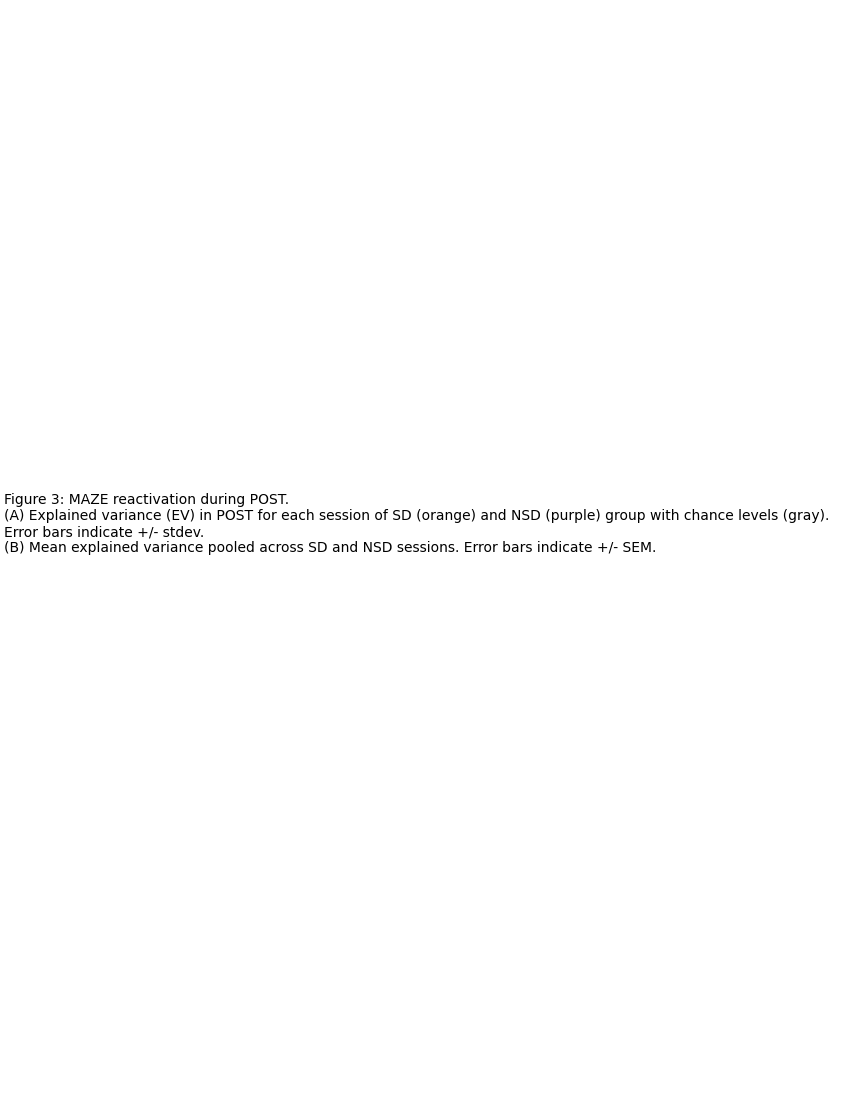

In [129]:
fig.savefig(filename,caption=caption)